In [ ]:
!python3 -m pip install -U git+https://github.com/facebookresearch/demucs#egg=demucs

In [ ]:
# Please BE VERY CAREFUL, this will link your entire drive.
# So don't edit code, except the one that says 'Customize the following options',
# or you might mess up your files.
# IF YOU DO NO WANT TO LINK DRIVE, please see below for an alternative!
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
# Customize the following options!
model = "htdemucs"
extensions = ["mp3", "wav", "ogg", "flac"]  # we will look for all those file types.
two_stems = None   # only separate one stems from the rest, for instance
# two_stems = "vocals"

# Options for the output audio.
mp3 = True
mp3_rate = 320
float32 = False  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!

in_path = '/gdrive/MyDrive/demucs/'
out_path = '/gdrive/MyDrive/demucs_separated/'

In [3]:
#@title Useful functions, don't forget to execute
import io
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO

from google.colab import files
model = "htdemucs_6s"
# Options for the output audio.
mp3 = True
mp3_rate = 320
float32 = False  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!
extensions = ["mp3", "wav", "ogg", "flac"]  # we will look for all those file types.
two_stems = None   # only separate one stems from the rest, for instance
# two_stems = "vocals"
in_path = '/gdrive/MyDrive/demucs/'
out_path = '/gdrive/MyDrive/demucs_separated/'

def find_files(in_path):
    out = []
    for file in Path(in_path).iterdir():
        if file.suffix.lower().lstrip(".") in extensions:
            out.append(file)
    return out

def copy_process_streams(process: sp.Popen):
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        # `select` syscall will wait until one of the file descriptors has content.
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(inp=None, outp=None):
    inp = inp or in_path
    outp = outp or out_path
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]
    if not files:
        print(f"No valid audio files in {in_path}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")


def from_upload():
    out_path = Path('separated')
    in_path = Path('tmp_in')

    if in_path.exists():
        rmtree(in_path)
    in_path.mkdir()

    if out_path.exists():
        rmtree(out_path)
    out_path.mkdir()

    uploaded = files.upload()
    for name, content in uploaded.items():
        (in_path / name).write_bytes(content)
    separate(in_path, out_path)

In [5]:
# This can be quite slow, in particular the loading, and saving from GDrive. Please be patient!
# This is from google drive! Also, this will separate all the files inside the MyDrive/demucs folder,
# so when you are happy with the results, remove the songs from there.
separate("/content/Imyours","/content/result")

Going to separate the files:
/content/Imyours/Imyours.mp3
With command:  python3 -m demucs.separate -o /content/result -n htdemucs_6s --mp3 --mp3-bitrate=320


Downloading: "https://dl.fbaipublicfiles.com/demucs/hybrid_transformer/5c90dfd2-34c22ccb.th" to /root/.cache/torch/hub/checkpoints/5c90dfd2-34c22ccb.th
100%|██████████| 52.4M/52.4M [00:00<00:00, 143MB/s]


Selected model is a bag of 1 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/result/htdemucs_6s
Separating track /content/Imyours/Imyours.mp3


100%|████████████████████████████████████████████████████████████████████████| 245.7/245.7 [00:15<00:00, 15.42seconds/s]


In [ ]:
# This is manual upload and download :)
from_upload()
!zip -r separated.zip separated
files.download('./separated.zip')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S   



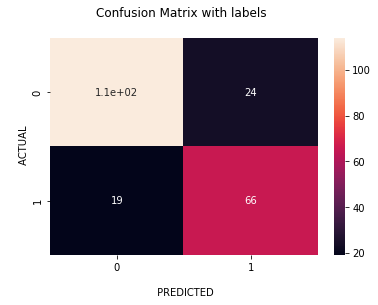

Columns in both x_test & test3 Index(['Sex-female', 'Sex-male', 'Cabin-A', 'Cabin-B', 'Cabin-C', 'Cabin-D',
       'Cabin-E', 'Cabin-F', 'Cabin-G', 'Cabin-X', 'Embarked-C', 'Embarked-Q',
       'Embarked-S', 'Pclass', 'Age', 'SibSp', 'Parch', 'Ticket_num', 'Fare'],
      dtype='object') 

Columns in x_test but not in test3 Index(['Cabin-T', 'Embarked-YY'], dtype='object') 

Columns in test3 but not in x_test Index([], dtype='object')
     PassengerId  Survived
0            892         0
1            893         1
2            894         1
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
     PassengerId  Survived
0            892         0
1            893         1
2            894         1
3            895         0
4            896         1
..           ...       ...
413         1305         

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv('/content/sample_data/train.csv')
test = pd.read_csv('/content/sample_data/test.csv')

## check train & test sets first 5 rows
print(train.head(5) , '\n\n')
print(test.head(5))

## check the shapes of the dataset
print(train.shape)
print(test.shape)

## check column names with data types
print(train.dtypes , '\n')
print(test.dtypes)

## check null/missing values
print(train.isnull().sum() , '\n')
print(test.isnull().sum())

## copy the dataset to new variables
train2 = train.copy()
test2 = test.copy()


## replace null values

train2['Age'] = train2['Age'].replace(np.NAN, train2['Age'].mean()) # replace by mean value
train2['Cabin'] = train2['Cabin'].replace(np.NAN, 'XX')
train2['Embarked'] = train2['Embarked'].replace(np.NAN, 'YY')

test2['Age'] = test2['Age'].replace(np.NAN, test2['Age'].mean()) # replace by mean value
test2['Cabin'] = test2['Cabin'].replace(np.NAN, 'XX')
test2['Fare'] = test2['Fare'].replace(np.NAN, test2['Fare'].mean())


## check no null/missing values
print(train2.isnull().sum() , '\n')
print(test2.isnull().sum())

##check Data Dictionary at https://www.kaggle.com/competitions/titanic/data

oHE = OneHotEncoder(sparse = False)

## Sex // train
print(train2['Sex'].value_counts().to_frame().sort_values('Sex'))
Sex1 = pd.DataFrame(oHE.fit_transform(train2[['Sex']]))
Sex1.columns = ['Sex-female', 'Sex-male']
print(Sex1.head(10))


## Sex // test
print(test2['Sex'].value_counts().to_frame().sort_values('Sex'))
Sex2 = pd.DataFrame(oHE.fit_transform(test2[['Sex']]))
Sex2.columns = ['Sex-female', 'Sex-male']
print(Sex2.head(10))


Cb1 = pd.DataFrame(train2['Cabin'].str.get(0))
print(Cb1.value_counts().to_frame().sort_values('Cabin'))
Cabin1 =pd.DataFrame(oHE.fit_transform(Cb1))
Cabin1.columns = ['Cabin-A', 'Cabin-B', 'Cabin-C', 'Cabin-D', 'Cabin-E', 'Cabin-F', 'Cabin-G', 'Cabin-T', 'Cabin-X']
print(Cabin1.head(10))

cb2 = pd.DataFrame(test2['Cabin'].str.get(0))
print(cb2.value_counts().to_frame().sort_values('Cabin'))
Cabin2 = pd.DataFrame(oHE.fit_transform(cb2))
Cabin2.columns = ['Cabin-A', 'Cabin-B', 'Cabin-C', 'Cabin-D', 'Cabin-E', 'Cabin-F', 'Cabin-G', 'Cabin-X']
print(Cabin2.head(10))

print(train2['Embarked'].value_counts().to_frame().sort_values('Embarked'))
Embarked1 = pd.DataFrame(oHE.fit_transform(train2[['Embarked']]))
Embarked1.columns = ['Embarked-C', 'Embarked-Q', 'Embarked-S', 'Embarked-YY']
print(Embarked1.head(10))

print(test2['Embarked'].value_counts().to_frame().sort_values('Embarked'))
Embarked2 = pd.DataFrame(oHE.fit_transform(test2[['Embarked']]))
Embarked2.columns = ['Embarked-C', 'Embarked-Q', 'Embarked-S']
print(Embarked2.head(10))

train2['Ticket_num'] = train2['Ticket'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
test2['Ticket_num'] = test2['Ticket'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
print (train2['Ticket_num'].head(5), '\n', test2['Ticket_num'].head(5))

scl = StandardScaler()

scl_train = pd.DataFrame(scl.fit_transform(train2[['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket_num', 'Fare']]))
scl_train.columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket_num', 'Fare']
print(scl_train.head(5))

scl_test = pd.DataFrame(scl.fit_transform(test2[['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket_num', 'Fare']]))
scl_test.columns = ['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket_num', 'Fare']
print(scl_test.head(5))

Survived_train = pd.DataFrame(train2['Survived'])

train3 = pd.concat([Survived_train, Sex1, Cabin1, Embarked1, scl_train], axis =1).reset_index(drop = True)
print(train3.shape, '\n')
print(train3.head(5))

test3 = pd.concat([Sex2, Cabin2, Embarked2, scl_test], axis =1).reset_index(drop = True)
print(test3.shape, '\n')
print(test3.head(5))

## check if any null value produced
print(train3.isnull().sum(), '\nn')
print(test3.isnull().sum())

## replace four null values in 'Ticket_num'
train3['Ticket_num'] = train3['Ticket_num'].replace(np.NAN, train3['Ticket_num'].mean())
train3.isnull().sum()

X = train3.drop('Survived', axis = 1)
Y = train3['Survived']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

## define the model
LG = LogisticRegression(solver = 'liblinear', random_state = 0)
LG.fit(x_train, y_train)

## check coefficients
print('Coefficients :' , LG.coef_ , 'Intercept :', LG.intercept_)
print('Coefficient of determination : ', LG.score(x_train, y_train))

y_pred = pd.Series(LG.predict(x_test))
y_pred.value_counts()

## confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm, '\n')
print(classification_report(y_test, y_pred, target_names = ['class 0', 'class 1']))


cmp = sns.heatmap(cm, annot = True)

cmp.set_title('Confusion Matrix with labels \n')
cmp.set_xlabel('\n PREDICTED')
cmp.set_ylabel('\n ACTUAL')

cmp.xaxis.set_ticklabels(['0', '1'])
cmp.yaxis.set_ticklabels(['0', '1'])
plt.show()

print('Columns in both x_test & test3', x_test.columns.intersection(test3.columns), '\n')
print('Columns in x_test but not in test3', x_test.columns.difference(test3.columns), '\n')
print('Columns in test3 but not in x_test', test3.columns.difference(x_test.columns))

test3['Cabin-T'] = 0
test3['Embarked-YY'] = 0


y_pred_Test = pd.Series(LG.predict(test3))
y_pred_Test.value_counts()

id = test['PassengerId'].to_frame('PassengerId').reset_index(drop = True)
sv = y_pred_Test.to_frame('Survived').reset_index(drop = True)

df_LG = pd.concat([id, sv], axis = 1)
print(df_LG )

id = test['PassengerId'].to_frame('PassengerId').reset_index(drop = True)
sv = y_pred_Test.to_frame('Survived').reset_index(drop = True)

df_LG = pd.concat([id, sv], axis = 1)
print(df_LG )